In [69]:
# Para no tener que reiniciar el kernel de jupyter cuando se hacen cambios en el archivo .py
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
# Carga de paquetes necesarios para graficar
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Para leer archivos
import geopandas as gpd # Para hacer cosas geográficas
import seaborn as sns # Para hacer plots lindos
import networkx as nx # Construcción de la red en NetworkX
import scipy
from template_funciones import *

# Preambulo

En esta sección cargamos los datos y los visualizamos. También construimos la matriz de adyacencia de la red de museos.

## Carga de datos de los museos

El listado de los museos, con el que se construye el [mapa](https://mapas.museosabiertos.org/museos/caba/), lo podemos encontrar [acá](https://github.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/blob/principal/data/export.geojson?short_path=bc357f3). También descargamos los barrios de CABA como complemento para los gráficos.

In [71]:
# Leemos el archivo, retenemos aquellos museos que están en CABA, y descartamos aquellos que no tienen latitud y longitud
museos = gpd.read_file('https://raw.githubusercontent.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/refs/heads/principal/data/export.geojson')
barrios = gpd.read_file('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.geojson')

In [86]:
museum_names = museos['name']
print(museum_names)

0                               Manzana de las Luces
1            Museo de Arte Español 'Enrique Larreta'
2                            Museo del Banco Central
3      Museo de Arte Latinoamericano de Buenos Aires
4          Museo de artes plásticas 'Eduardo Sívori'
                           ...                      
131                       Museo de Ciencia y Técnica
132                        Museo de la Deuda Externa
133                                       Museo Iser
134                Museo Histórico Vecinal de Flores
135                                Museo Franciscano
Name: name, Length: 136, dtype: object


## Visualización

<Axes: >

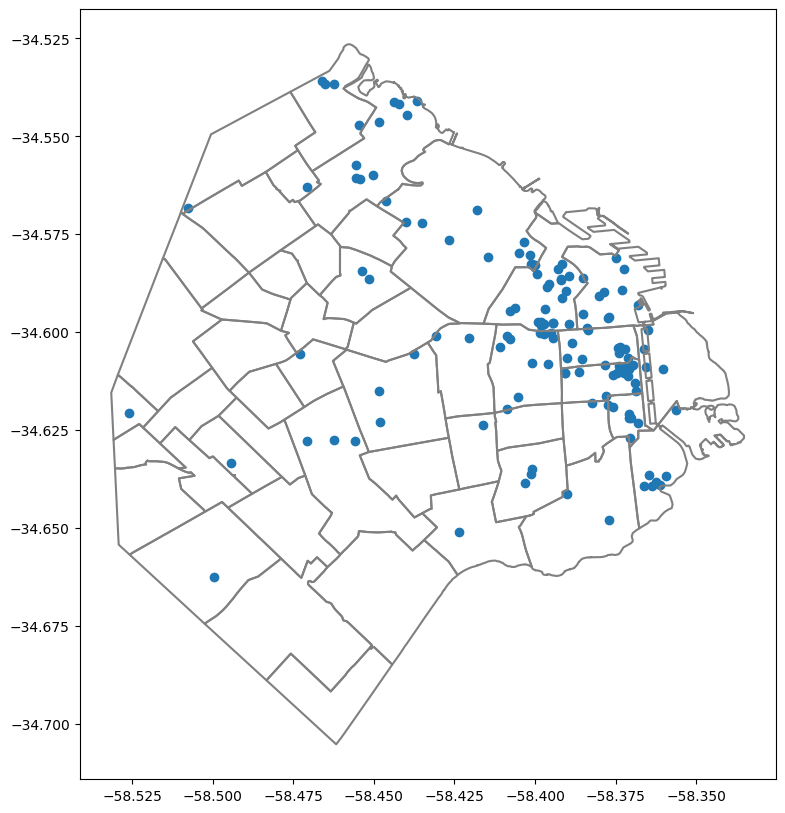

In [72]:
# Armamos el gráfico para visualizar los museos
fig, ax = plt.subplots(figsize=(10, 10))
barrios.boundary.plot(color='gray',ax=ax)
museos.plot(ax=ax)

## Cálculo de la matriz de distancias

Ahora construimos la matriz de distancias entre todos los museos. Como la tierra es un [geoide](https://es.wikipedia.org/wiki/Geoide) (es decir que no es [plana](https://es.wikipedia.org/wiki/Terraplanismo)), el cálculo de distancias no es una operación obvia. Una opción es proyectar a un [sistema de coordenadas local](https://geopandas.org/en/stable/docs/user_guide/projections.html), de forma tal que las distancias euclideas se correspondan con las distancias en metros. En este notebook usamos [EPSG](https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset) 22184. 

In [73]:
# En esta línea:
# Tomamos museos, lo convertimos al sistema de coordenadas de interés, extraemos su geometría (los puntos del mapa), 
# calculamos sus distancias a los otros puntos de df, redondeamos (obteniendo distancia en metros), y lo convertimos a un array 2D de numpy
D = museos.to_crs("EPSG:22184").geometry.apply(lambda g: museos.to_crs("EPSG:22184").distance(g)).round().to_numpy()

### Matriz de adyacencia: construimos una matriz conectando a cada museo con los $m$ más cercanos

In [74]:
m = 3 # Cantidad de links por nodo
A = construye_adyacencia(D,m)

## Construcción de la red en NetworkX (sólo para las visualizaciones)

In [75]:
G = nx.from_numpy_array(A) # Construimos la red a partir de la matriz de adyacencia
# Construimos un layout a partir de las coordenadas geográficas
G_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}

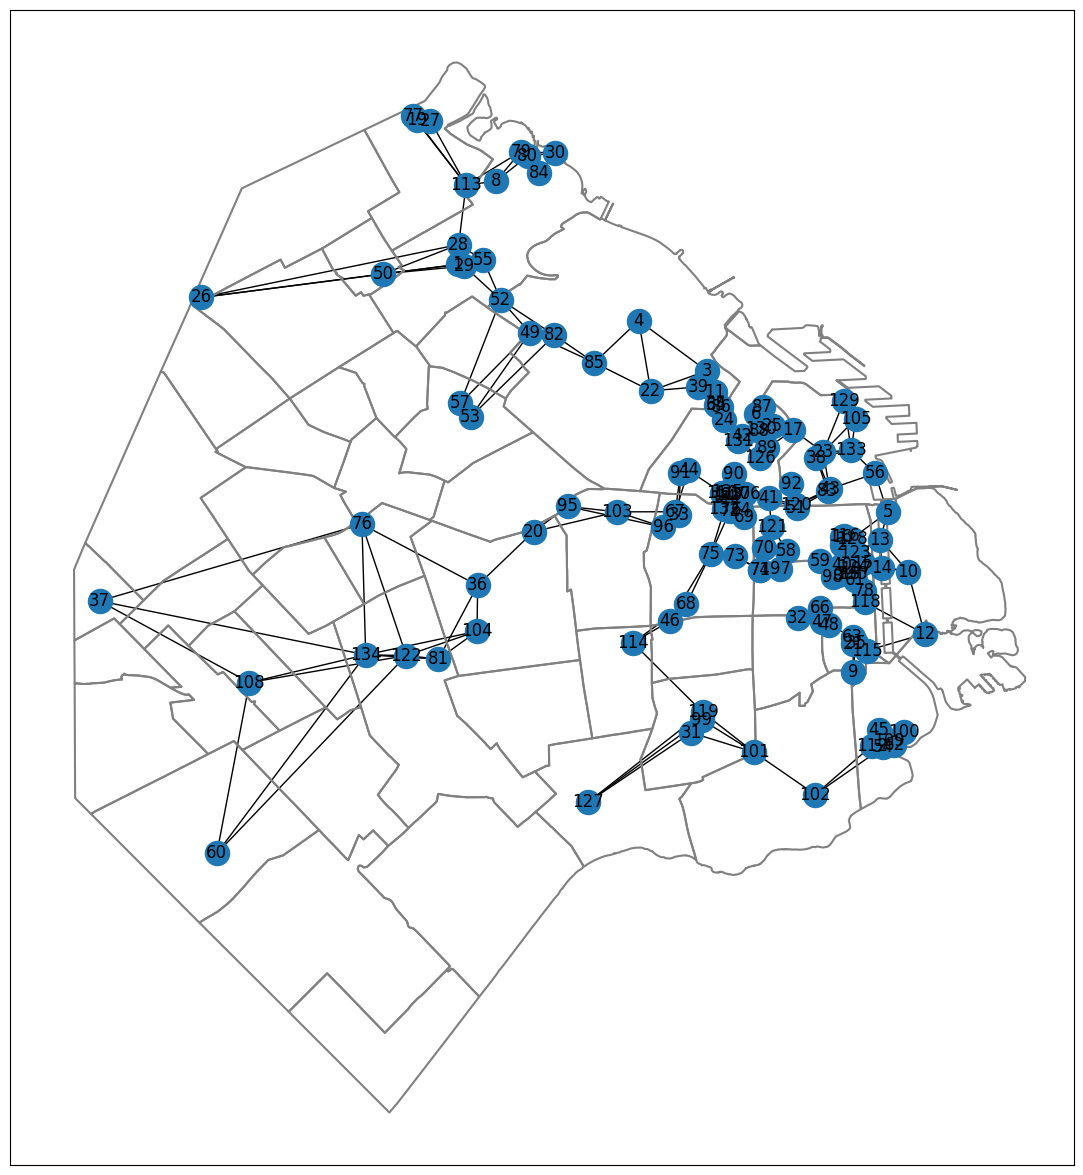

In [76]:
fig, ax = plt.subplots(figsize=(15, 15)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
nx.draw_networkx(G,G_layout,ax=ax) # Graficamos los museos

# Resolución del TP

Aquí empieza la aventura... ¡diviertanse y consulten lo que necesiten!

## Punto 1:

Partiendo de la definicion de p
$$
p = (1-\alpha)Cp + \frac{\alpha}{N}\textbf{1} \\
p - (1-\alpha)Cp = \frac{\alpha}{N}\textbf{1} \\
(I + (1-\alpha)C)p = \frac{\alpha}{N}\textbf{1}\\
\frac{N}{\alpha}(I + (1-\alpha)C)p = \textbf{1}\\
Mp = \textbf{1} = b\\
$$
Se llega al sistema. Por lo tanto $p$ es solucion del sistema por su definicion.

$\square$

## Punto 2:


Para que la ecuación del punto anterior tenga una única solucion, la matriz $M$ debe ser invertible. Para que $M$ sea invertible su determinante debe ser distinto de 0, es decir $ \text{det}(M) \neq 0 $

Usamos la  propiedad del determinante: $\text{det}(kA)=k^n \cdot \text{det}(A)$ donde $k$ es un escalar y $n$ es la dimensión de la matriz.

Por lo tanto:

$$ \text{det}(M) = \text{det}(\frac{N}{\alpha}(I-(1-\alpha)C))=(\frac{N}{\alpha})^N \text{det}(I-(1-\alpha)C) $$

$\frac{N}{\alpha}$ es un escalar positivo, ya que $N > 0$ y $0 < \alpha < 1$, $\text{det}(M) \neq 0$ si y sólo si $\text{det}(I - (1-\alpha)C)\neq 0$.

Probar que el determinante no es nulo es equivalente a probar si la matriz es inversible, así que ahora vamos a probar si la matriz $I - (1-\alpha)C$ es inversible. 

Sabemos que $C$ es una matriz estocástica por columnas, por lo que $||C||_1 = 1$ y ya que $0 < \alpha <1$ entonces $0 < (1 - \alpha) < 1$. Llamo $\beta$ a $1-\alpha$.

Con esto podemos decir que $0 < ||\beta C||_1 < 1$ ya que $||\beta C||_1 = |\beta|·||C||_1$ y $|\beta| = \beta$ porque $\beta > 0$.
  
Ahora vamos a probar que la matriz $I - \beta C$ es inversible debido a que $||\beta C||_1 < 1$.

Si no fuera inversible, existiría un vector no nulo $x$ tal que: 

$$ (I - \beta C)x = 0 \implies x - (\beta C)x = 0 \implies x = (\beta C)x \implies ||x||_1 = ||(\beta C)x||_1 $$

Por la propiedad submultiplicativa de las normas matriciales:

$$ ||(\beta C)x||_1 \leq ||x||_1 · ||(\beta C)||_1 $$

y ya que $||x||_1 = ||(\beta C)x||_1$ entonces:

$$ ||x||_1 \leq ||x||_1 · ||(\beta C)||_1 \implies 1 \leq ||(\beta C)||_1 $$

Lo cual es un absurdo ya que partimos de la hipótesis de que $||(\beta C)||_1 < 1$.

Por lo que $(I - \beta C)$ debe ser inversible lo que implica que $\text{det}(I - (1-\alpha)C)\neq 0$.

$\square$

## Punto 3:

##### Funciones auxiliares

Para calcular los ranks, primero queremos hacer una función para calcular la matriz de grados $K$.

La función $\texttt{construir\_matriz\_grado}$ toma como parametro de entrada la matriz de adyacencias $A$ que construimos a partir de leer los datos de los museos y calculando sus distancias y retorna la matriz de grados $K$ donde

$$ K_{ij} = \begin{cases} 
\sum^{N}_{h=1} A_{ih}, \qquad i=j \\
0, \qquad \qquad \quad i\neq j
\end{cases} $$

Luego, necesitamos la inversa $K^{-1}$, esto lo podemos obtener calculando la solución el sistema triangular $(K|I)$. 

Creamos la función $\texttt{inversa\_de\_triangular}$ toma como entrada una matriz triangular $M$ y resuelve el sistema $(M|I)$ para encontrar la inversa $M^{-1}$

La función $\texttt{calcula\_matriz\_C}$ toma la matriz $A$, calcula $K$ y retorna $C = A^T K^{-1}$.

##### Cálculo de Page Ranks

La solución al sistema $M\textbf{p}=\textbf{b}$ con $\textbf{b} = \textbf{1}$ será la matriz de puntajes.

Para resolver el sistema creamos la función $\texttt{calcula\_pagerank}$ toma una matriz de transiciones $C$, construye la matriz $M=\frac{N}{\alpha}(I-(1-\alpha)C)$ y retorna la solución al sistema $M\textbf{p}=\textbf{b}$ con $\textbf{b} = \textbf{1}$ utilizando descomposición LU.

### 3.a 

Construimos la red conectando a cada museo con sus $m = 3$ vecino más cercanos y procedemos a graficar la red asignando un tamaño proporcional a cada nodo según su Page Rank, para ello utilizamos la función calcular_puntajes definida anteriormente. 

In [77]:

Nprincipales = 5 # Cantidad de principales
m = 3 # Cantidad de vecinos mas cercanos
d = 1/5 # factor de dumping
pr = calcular_p(D, m, d)

# identificar museos mas centrales
principales = np.argsort(pr)[-3:]
print(principales)

[ 18 125 117]


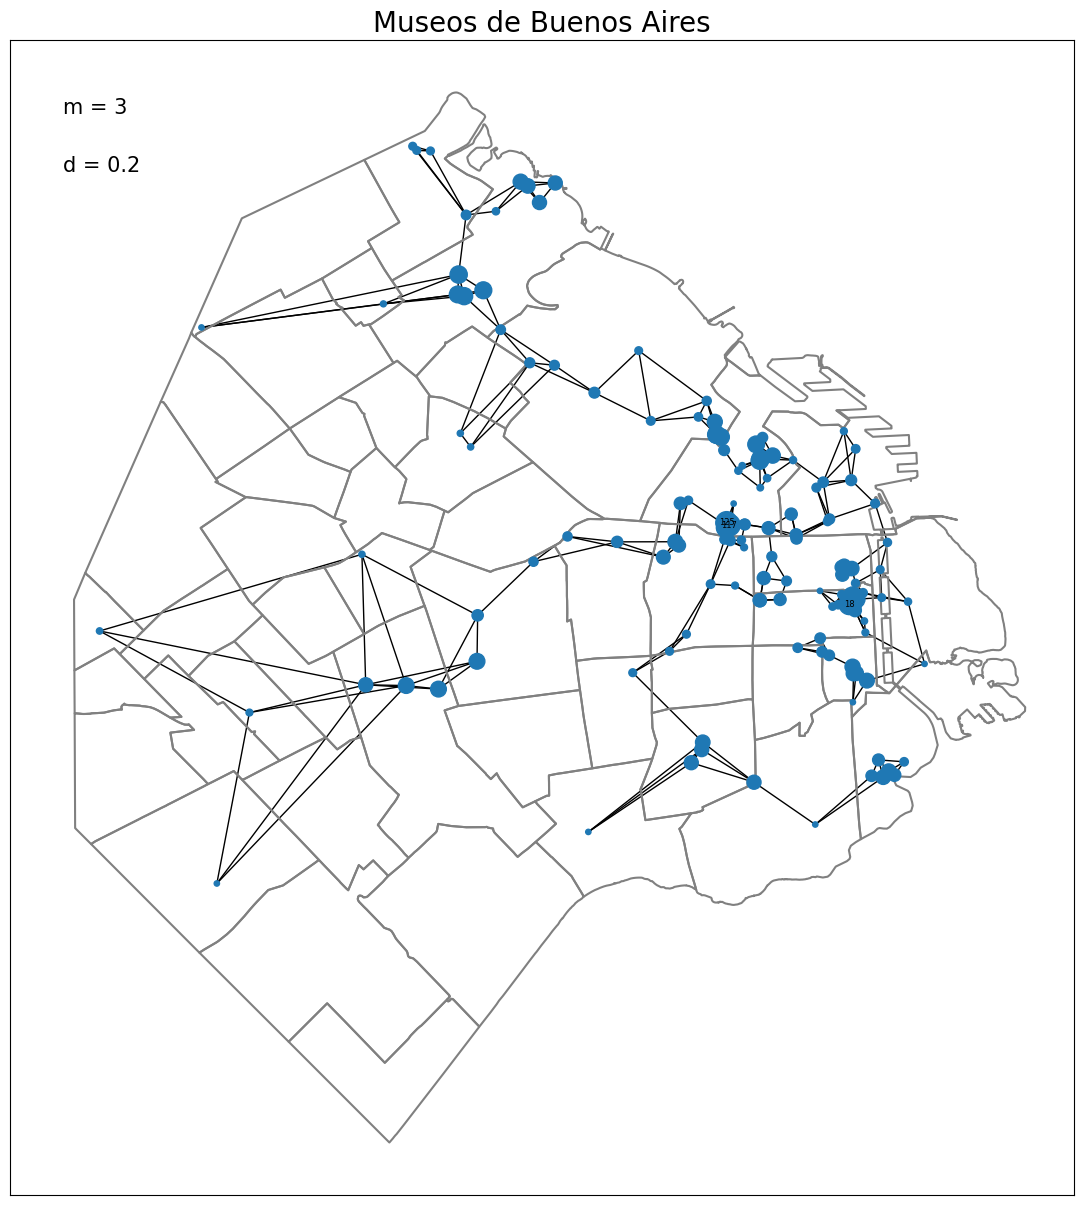

In [78]:
graficar_red_p(pr, A, m, d, museos, barrios, Nprincipales=3)

### 3.b) m = 1, 3, 5, 10 y usando α = 1/5
TODO: RESPONDER

¿Son estables las posiciones en el ranking? Describa los distintos patrones que observa,
identificando que ubicaciones son relevantes encada caso. 
¿Hay museos que solo son relevantes en redes con pocas conexiones?
¿O museos que se vuelven mas relevantes mientras mas conexiones aparecen?

¿Que regiones se vuelven mas predominantes al aumentar α? ¿Y al aumentar m?

In [79]:
ms = [1, 3, 5, 10] 
d = 1/5
ps = [] # Lista de scores page rank para cada m y d
for m in ms:
    pr = calcular_p(D, m, d)
    ps.append(pr)

Museo Nacional de Arte Oriental
Museo Nacional de Arte Decorativo
Museo Franciscano
Museo del antiguo recinto del Congreso Nacional
Museo Casa Rosada
Museo de la Ciudad
Museo de Odontología
Museo de Farmacobotánica
Museo Histórico de la AFIP
Museo de la Facultad de Odontología
[ 65  34 135 107  15  18  93 117 124 125]


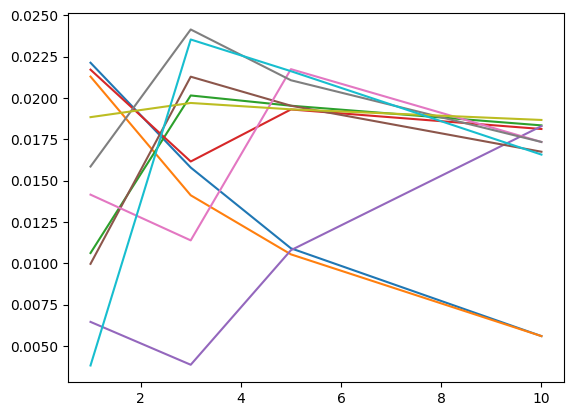

In [80]:
# TODO: Agregar los axis, labels de cada museo. Hacer lo mismo para el C.
def graficar_museos_principales_por_M(ps, ms, d):
    # Grafica como cambia el ranking de los 3 principales museos para distintos valores de M.
    tres_principales_cada_m = []
    for i, p in enumerate(ps):
        principales = np.argsort(p)[-3:]
        tres_principales_cada_m.append(principales)


    tres_principales_cada_m = np.array(list(set(np.hstack(tres_principales_cada_m)))) # Eliminar duplicados con set
    for X in tres_principales_cada_m:
        print(museos.loc[X, 'name'])
    print(tres_principales_cada_m)

    ranking = []
    for i, p in enumerate(ps):
        ranking.append(ps[i][tres_principales_cada_m])
    plt.plot(ms, ranking)

graficar_museos_principales_por_M(ps, ms, d)

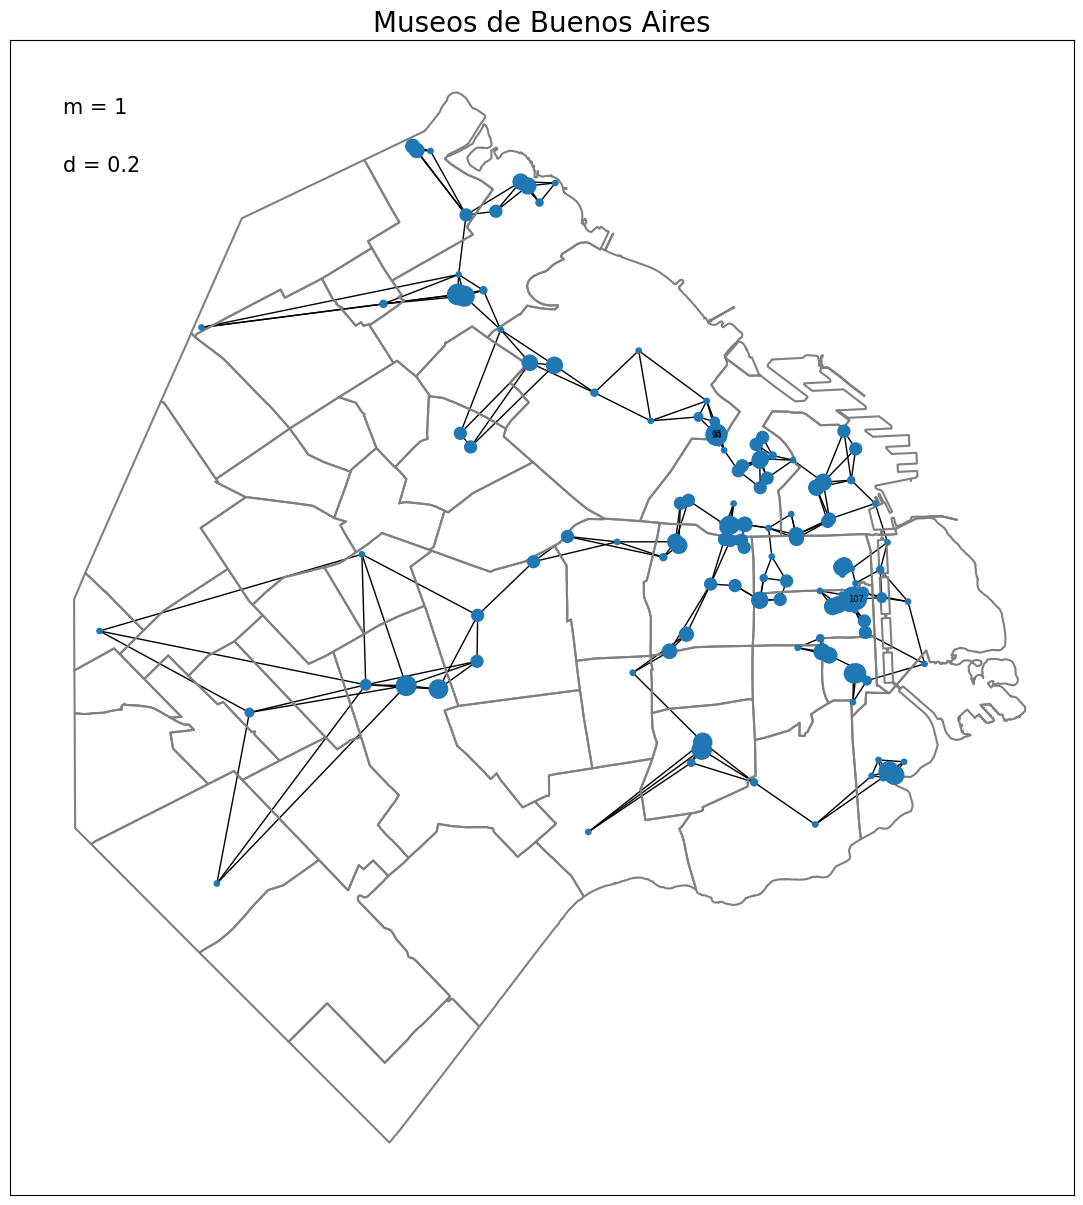

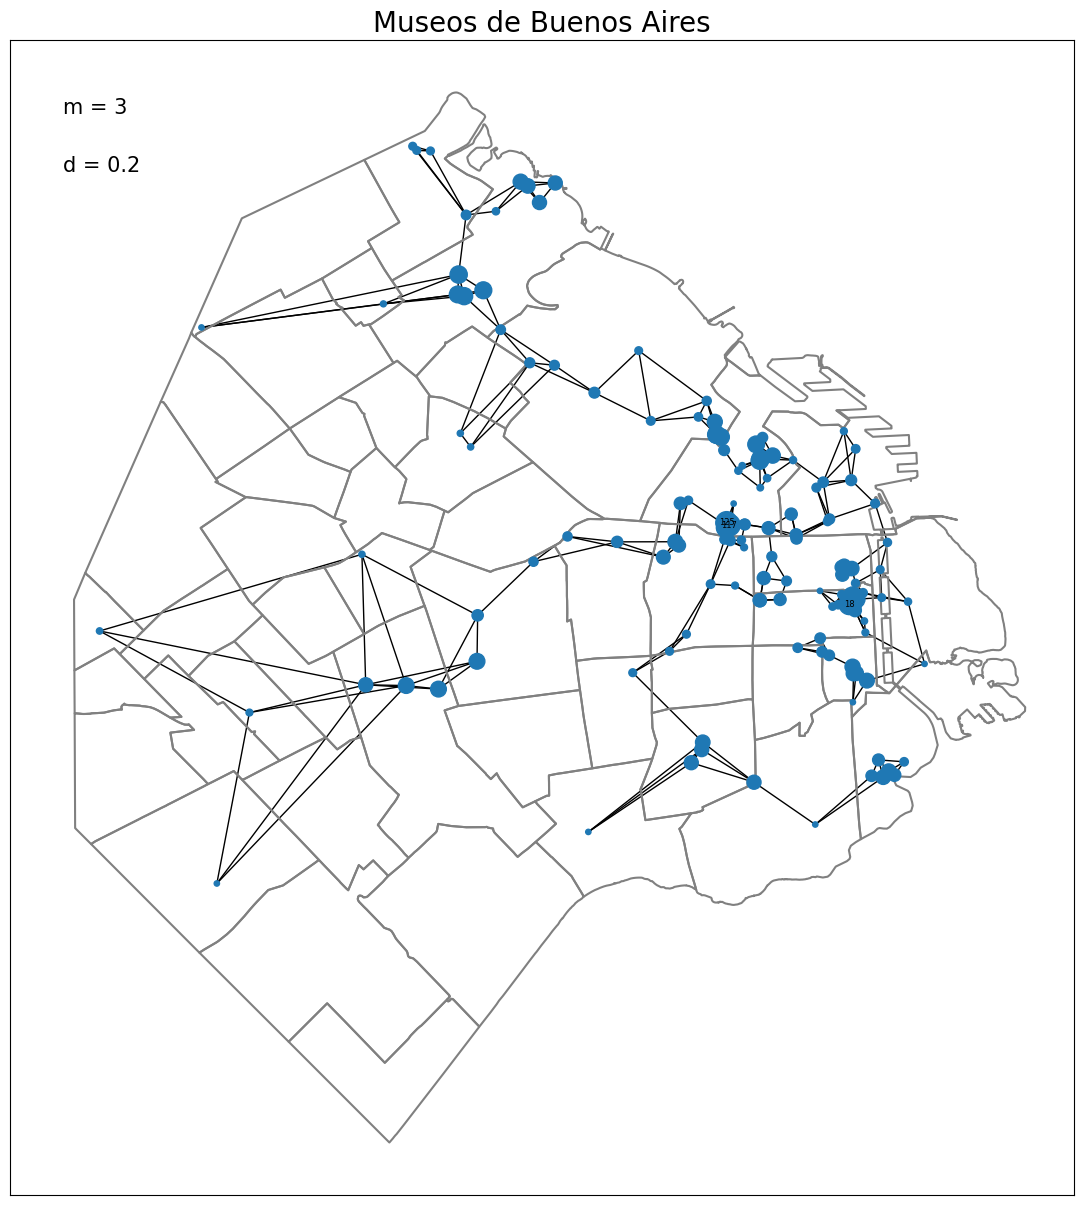

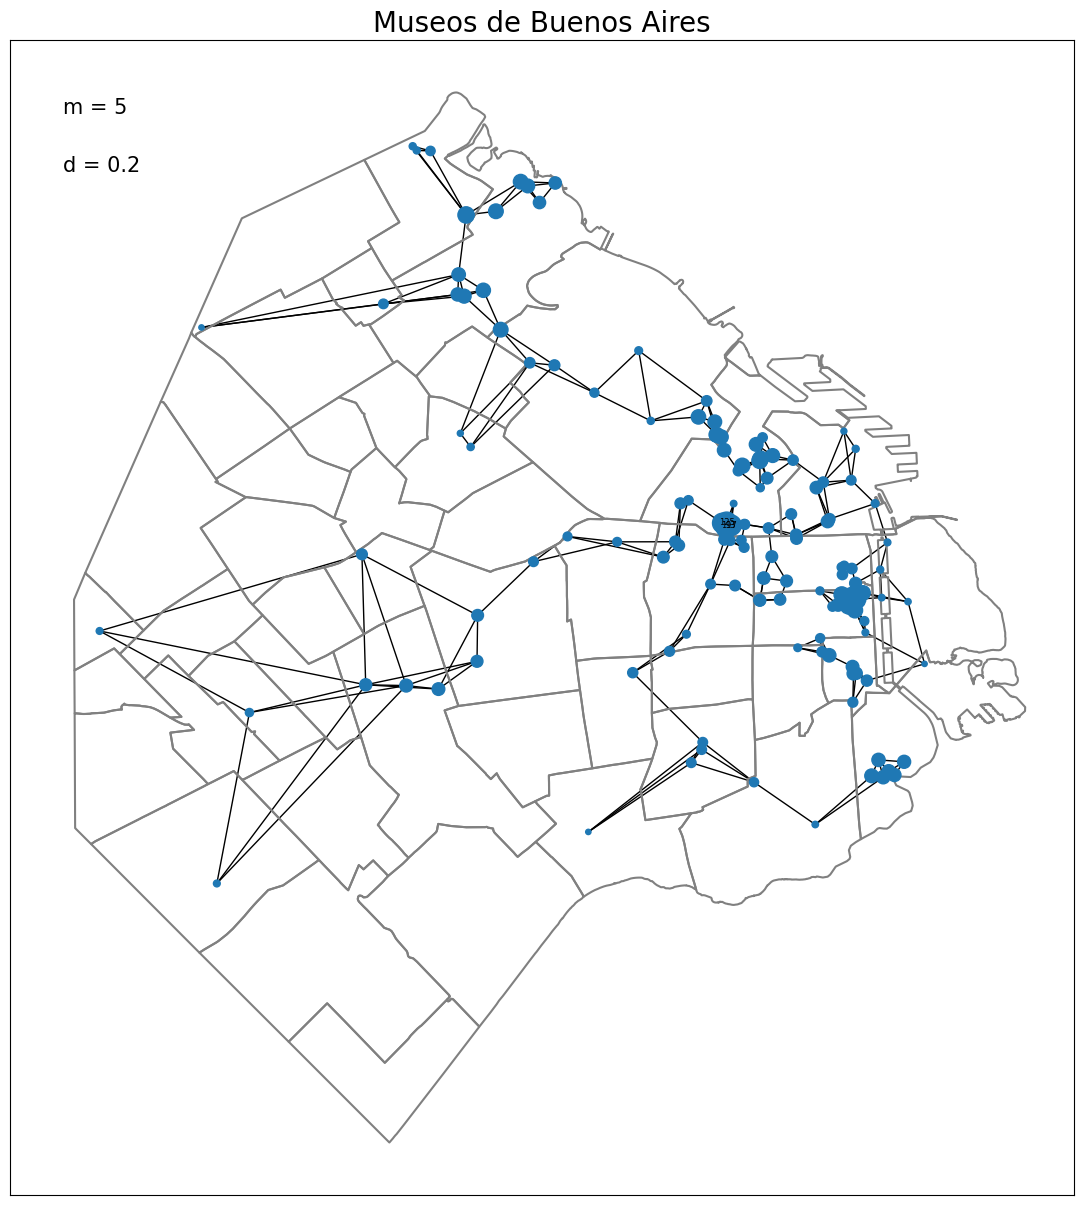

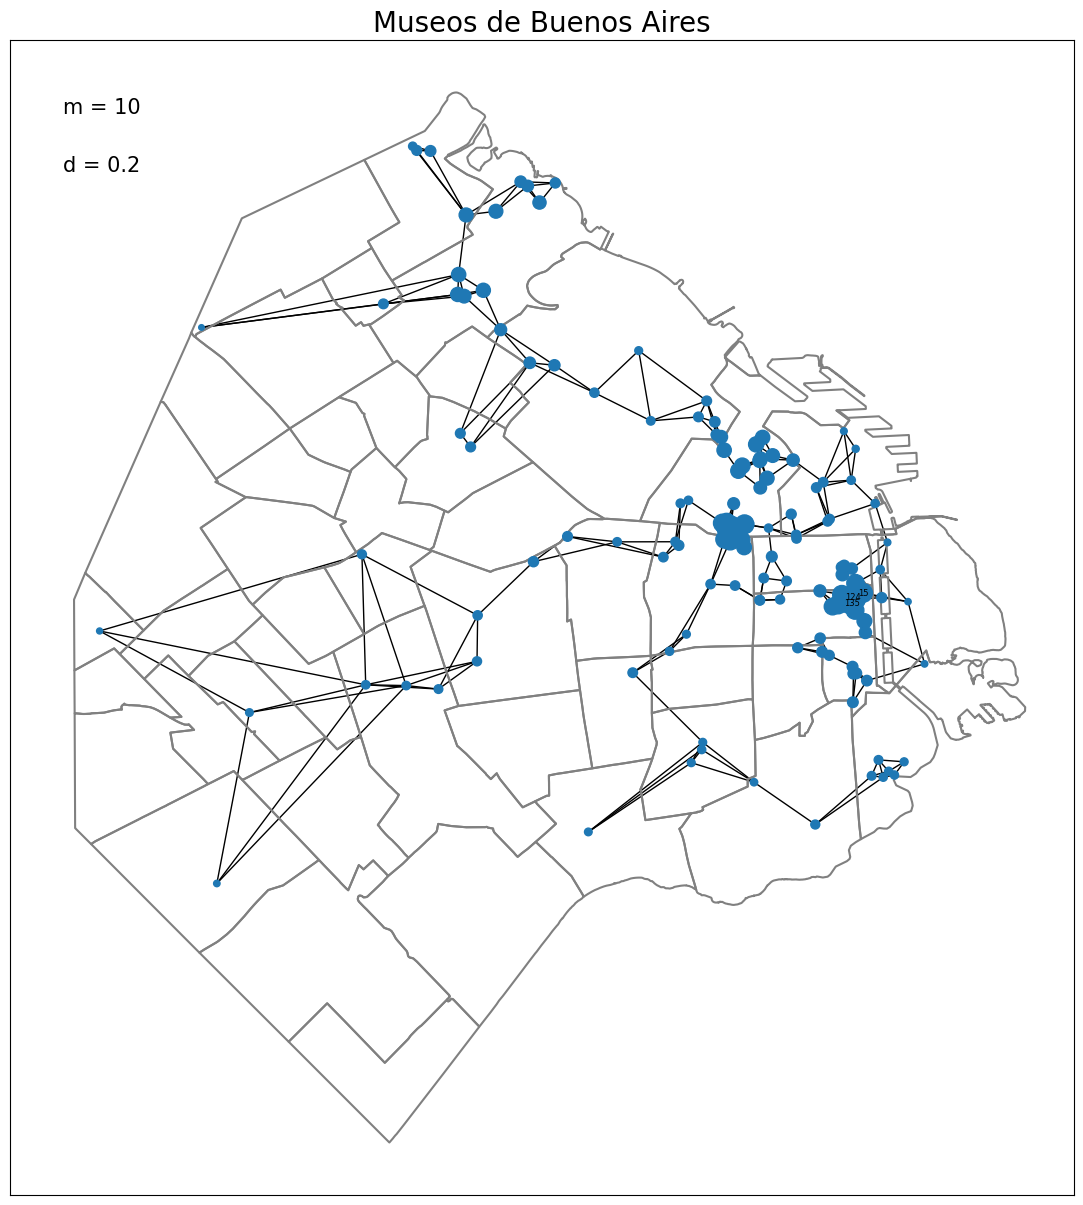

In [81]:
# Mapas para cada par m, d
for i, p in enumerate(ps):
    graficar_red_p(p, A, ms[i], d, museos, barrios, Nprincipales=3)
    

### 3.c) m = 5 y α = 6/7, 4/5, 2/3, 1/2, 1/3, 1/5, 1/7

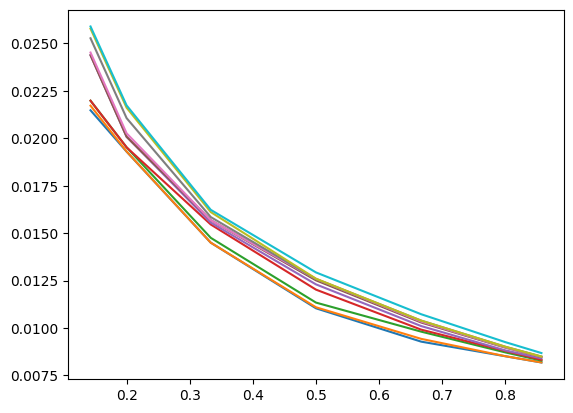

In [82]:
m = 5
ds = [6/7, 4/5, 2/3, 1/2, 1/3, 1/5, 1/7]
ps = []
for d in ds:
    pr = calcular_p(D, m, d)
    principales = np.argsort(pr)[-10:]
    ps.append(pr[principales])
    # pr = calcular_p(D, m, d)
    # # identificar museos mas centrales
    # principales = np.argsort(pr)[-3:]
    # print(principales)
    # graficar_red_p(pr, A, m, d, museos, barrios, Nprincipales=3)

plt.plot(ds, ps)

## Punto 4:

Supongamos que cada persona que ingresa a la red de museos realiza exactamente $r$ visitas antes de abandonar la misma. Sean:

- $\textbf{v} \in \mathbb{R}^N$ el vector que indica la cantidad de personas que ingresaron por primera vez a cada museo, es decir la primera visita.
- $\textbf{w} \in \mathbb{R}^N$ el vector que contiene el número total de visitas que recibió cada museo, contando todas las visitas en los $r$ pasos de cada visitante.
- $C \in \mathbb{R}^{N \times N}$ la matriz de transición de la red de museos.

Sabiendo que luego de $k$ pasos, la distribución de visitantes es $C^k \textbf{v}$, la cantidad total de visitas que recibió cada museo luego de $r$ pasos es la suma de todas las visitas recibidas en los $r-1$ pasos anteriores, es decir

$$ \textbf{w} = \underbrace{\textbf{v}}_{\text{1er visita}} + \underbrace{C\textbf{v}}_{\text{2da visita}} + \underbrace{C^2\textbf{v}}_{\text{3ra visita}} + \cdots + \underbrace{C^{r-1}\textbf{v}}_{r-1\text{-ésima visita}} $$

Luego, sacando a $\textbf{v}$ como factor común tenemos $$ \textbf{w} = (I + C + C^2 + \cdots + C^{r-1}) \textbf{v} $$

$$ \textbf{w} = \left( \sum_{k=0}^{r-1} C^k \right) \textbf{v} $$

llamamos $B = \sum_{k=0}^{r-1} C^k$, de este modo nos queda

$$ \textbf{w} = B\textbf{v} $$

Si asumimos que $B$ es inversible, podemos despejar $\textbf{v}$ como

$$ \textbf{v} = B^{-1}\textbf{w} $$

Que es lo que queríamos probar.

$\square$

## Punto 5:

Nos piden calcular la cantidad total de visitantes que entraron en la red, es decir $||v||_1$,  utilizando la ecuación del punto 4.

$$ \textbf{v} = B^{-1} \textbf{w} $$

Para esto, creamos la función $\texttt{calcula\_matriz\_C\_continua}$ que recibe la matriz de distancias $D$ y calcula $C$ donde

$$ C_{ij}= \frac{f(d_{ij})}{\sum^{N}_{k=1,k\neq i}f(d_{ik})} $$

y la función $\texttt{calcula\_B}$ que toma la matriz $C$ y el número de pasos $r$ y retorna la matriz $B$ donde $$B = \sum^{r-1}_{k=0} C^k$$

FInalmente construimos una función $\texttt{calcular\_norma\_v}$ que recibe como parametros el vector $\textbf{w}$ y la matriz de adyacencias $A$ para encontrar $\textbf{v}$ y retornar su norma.

/home/ncarrasco/repos/alc-tp1-1c2025/template_funciones.py:152: RuntimeWarning: divide by zero encountered in divide
  F = 1/D


0
1
0
1
La cantidad total de visitantes que entraron a la red es  136605.0


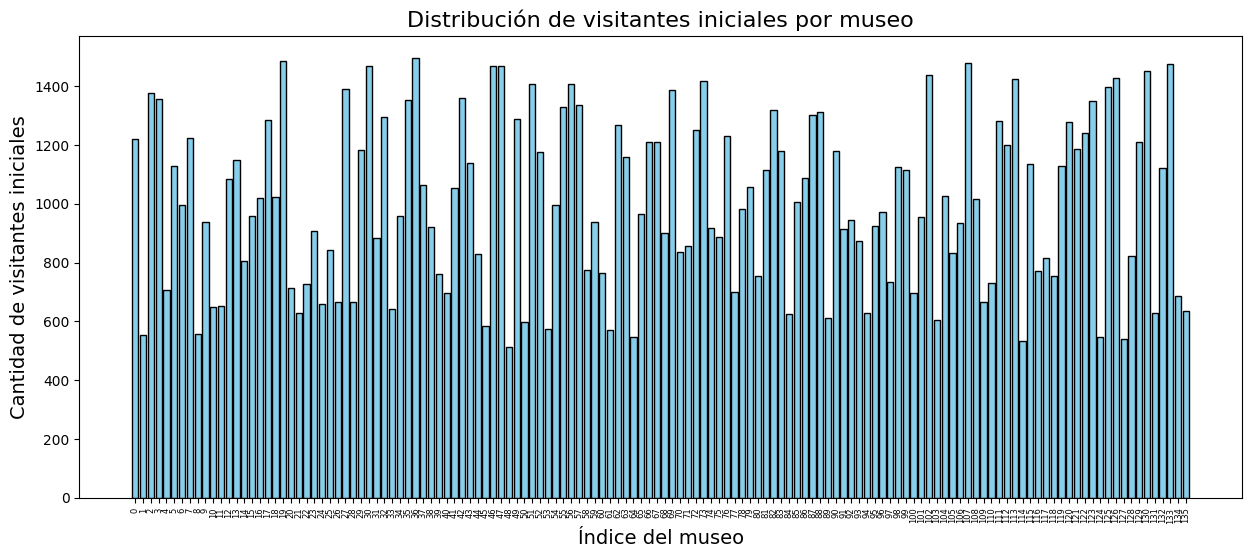

In [ ]:
# Construimos el vector w con los datos de visitas.txt
w = np.loadtxt("visitas.txt")
# Definimos la cantidad de visitas
r = 3

# Obtenemos el vector de visistas iniciales v y su norma resolviendo la ecuación
norma_v = calcular_norma_v(D, w, r)[0]
v = calcular_norma_v(D, w, r)[1]

# Imprimimos la norma de v y graficamos
print("La cantidad total de visitantes que entraron a la red es ",norma_v)
graficar_histograma_v(v)


## Punto 6:

Supongamos que el número total de visitantes por museo $w$ tiene un error del $5\%$. Queremos poder estimar de qué manera se propaga este error en la estimación del vector $v$ de visitantes iniciales.

Si llamamos $\overline{v}$ y $\overline{w}$ a los valores reales, podemos acotar el error de estimación de la siguiente manera

$$ \frac{||v-\overline{v}||_1}{||v||_1} \leq \text{cond}_1 (B) \frac{||w-\overline{w}||_1}{||w||_1}$$

En este caso como el error de $w$ es del $5\%$, entonces

$$ \frac{||v-\overline{v}||_1}{||v||_1} \leq 0.05 $$

In [84]:
# Calculamos la matriz B
C = calcula_matriz_C_continua(D)
B = calcula_B(C, 3)

# Calculamos el numero de condición de B
cond = np.linalg.cond(B,1)

print("Cond1(B): ", cond)
print("Cota: ", cond * 0.05)

0
1
Cond1(B):  5.051771176665004
Cota:  0.2525885588332502


/home/ncarrasco/repos/alc-tp1-1c2025/template_funciones.py:152: RuntimeWarning: divide by zero encountered in divide
  F = 1/D


# Extras

Para graficar la red con un conjunto de puntajes (como el Page Rank)

{0: Text(4924405.086723215, 6160838.106023658, ''),
 1: Text(4917216.80489522, 6166701.553530234, ''),
 2: Text(4924486.298584606, 6161409.256658559, ''),
 3: Text(4921922.052887296, 6164690.544542129, ''),
 4: Text(4920636.67547965, 6165640.199444978, ''),
 5: Text(4925338.320928778, 6162016.528710163, ''),
 6: Text(4922856.100832731, 6163868.567721188, ''),
 7: Text(4922641.894255253, 6162355.100129171, ''),
 8: Text(4917938.7521918025, 6168273.372961773, ''),
 9: Text(4924683.52693892, 6158996.617208998, ''),
 10: Text(4925725.9600755945, 6160896.846339954, ''),
 11: Text(4922075.10183836, 6164294.738410278, ''),
 12: Text(4926038.146946977, 6159721.190876993, ''),
 13: Text(4925200.592014585, 6161503.005610317, ''),
 14: Text(4925229.168803978, 6160973.145341254, ''),
 15: Text(4924875.410406244, 6161061.981187101, ''),
 16: Text(4924474.294424794, 6161547.549492302, ''),
 17: Text(4923553.755484842, 6163571.336254905, ''),
 18: Text(4924615.955668659, 6160843.2491330765, ''),
 19:

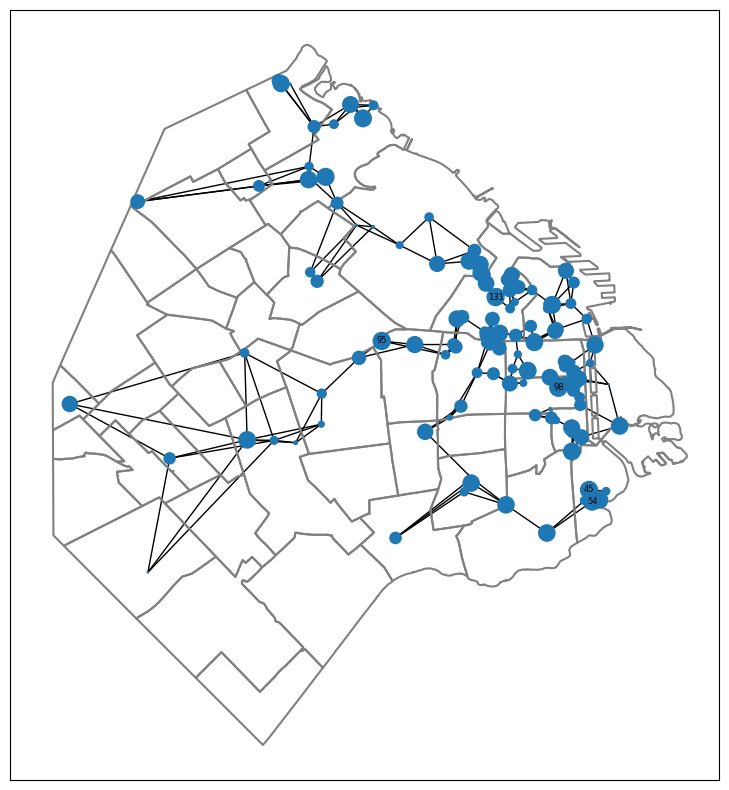

In [85]:
factor_escala = 1e4 # Escalamos los nodos 10 mil veces para que sean bien visibles
fig, ax = plt.subplots(figsize=(10, 10)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
pr = np.random.uniform(0,1,museos.shape[0])# Este va a ser su score Page Rank. Ahora lo reemplazamos con un vector al azar
pr = pr/pr.sum() # Normalizamos para que sume 1
Nprincipales = 5 # Cantidad de principales
principales = np.argsort(pr)[-Nprincipales:] # Identificamos a los N principales
labels = {n: str(n) if i in principales else "" for i, n in enumerate(G.nodes)} # Nombres para esos nodos
nx.draw_networkx(G,G_layout,node_size = pr*factor_escala, ax=ax,with_labels=False) # Graficamos red
nx.draw_networkx_labels(G, G_layout, labels=labels, font_size=6, font_color="k") # Agregamos los nombres